In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

from typing import Union, Tuple, List

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
df = pd.read_csv(r"/content/hodograph.csv", sep=',', header=0)

x = np.array(df["rec_x"])
y = np.array(df["rec_y"])
t_measured = np.array(df["time"])

# СЛАУ

In [ ]:
#y = Ax
A = np.vstack((np.ones_like(x), x**2+y**2))
#псевдообратная*у и сразу взял корень
solution = np.sqrt(np.square(t_measured)@np.linalg.pinv(A))
#медленность в скорость
solution[1] = 1/solution[1]
print(f"time:{solution[0]}\nvelocity: {solution[1]}")

time:0.20066750947634596
velocity: 1038.9119463407542


# Градиентный спуск

In [ ]:
def compute_gradient(weights: Union[Tuple[float, float], List[float], np.ndarray],
                     x: Union[List[float], np.ndarray],
                     y: Union[List[float], np.ndarray],
                     t_measured: Union[List[float], np.ndarray]
                    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the gradient of the cost function with respect to the weights.

    Parameters:
        weights (Union[Tuple[float, float], List[float], np.ndarray]): Current values of weights.
        x (Union[List[float], np.ndarray]): x-coordinates.
        y (Union[List[float], np.ndarray]): y-coordinates.
        t_measured (Union[List[float], np.ndarray]): Measured time data.

    Returns:
        Tuple[np.ndarray, np.ndarray]: Computed gradient and denominator.
    """
    t0, velocity = weights
    denominator = np.sqrt(t0**2 + (x**2 + y**2) / velocity**2)

    dt0 = -2 * np.sum((t_measured - denominator) * t0 / denominator) / len(t_measured)
    dvel = 2 * np.sum((t_measured - denominator) * (x**2 + y**2) / ((velocity**3) * denominator)) / len(t_measured)

    gradient = np.array([dt0, dvel])

    return gradient, denominator

def gradient_descent(weights: Union[Tuple[float, float], List[float], np.ndarray],
                     x: Union[List[float], np.ndarray],
                     y: Union[List[float], np.ndarray],
                     t_measured: Union[List[float], np.ndarray],
                     learning_rate: Union[List[float], np.ndarray],
                     niter: int, tol: float = 1e-6
                    ) -> Union[tuple, list, np.ndarray]:
    """
    Perform gradient descent optimization.

    Parameters:
        weights (Union[Tuple[float, float], List[float], np.ndarray]): Current values of weights.
        x (Union[List[float], np.ndarray]): x-coordinates.
        y (Union[List[float], np.ndarray]): y-coordinates.
        t_measured (Union[List[float], np.ndarray]): Measured time data.
        learning_rate (Union[List[float], np.ndarray]): Learning rate for gradient descent.
        niter (int): Number of iterations.
        tol (float): Convergence tolerance.

    Returns:
        Union[tuple, list, np.ndarray]: Optimized parameters.
    """
    path = []
    for _ in range(niter):
        gradient, time = compute_gradient(weights, x, y, t_measured)
        l2_norm = np.linalg.norm(t_measured - time, ord=2)
        path.append([*weights, l2_norm])
        if l2_norm < tol:
            break

        weights -= learning_rate * gradient

    return weights, path



In [ ]:
res = gradient_descent([0.05, 600], x, y, t_measured = t_measured,learning_rate = [0.05, 1e6],  niter = 10001, tol = 1e-4)
res[0]

array([2.00612790e-01, 1.03801744e+03])

In [ ]:
params = np.array(res[1])

In [ ]:
def residuals(weights: Union[Tuple[float, float], List[float], np.ndarray],
              x: Union[List[float], np.ndarray],
              y: Union[List[float], np.ndarray],
              t_measured: Union[List[float], np.ndarray]) -> float:
    """
    Calculate the residuals between measured time and computed time based on the weights.

    Parameters:
        params (tuple): Tuple containing t0 and v, the parameters to be optimized.
        x (array-like): x-coordinates of the data points.
        y (array-like): y-coordinates of the data points.
        t_measured (array-like): Measured time data corresponding to the given coordinates.

    Returns:
        float: L2 norm of the residuals.
    """
    t0, v = weights

    time_new = np.sqrt(t0**2 + (x**2+y**2)/(v**2))

    return np.linalg.norm(t_measured - time_new, ord= 2)

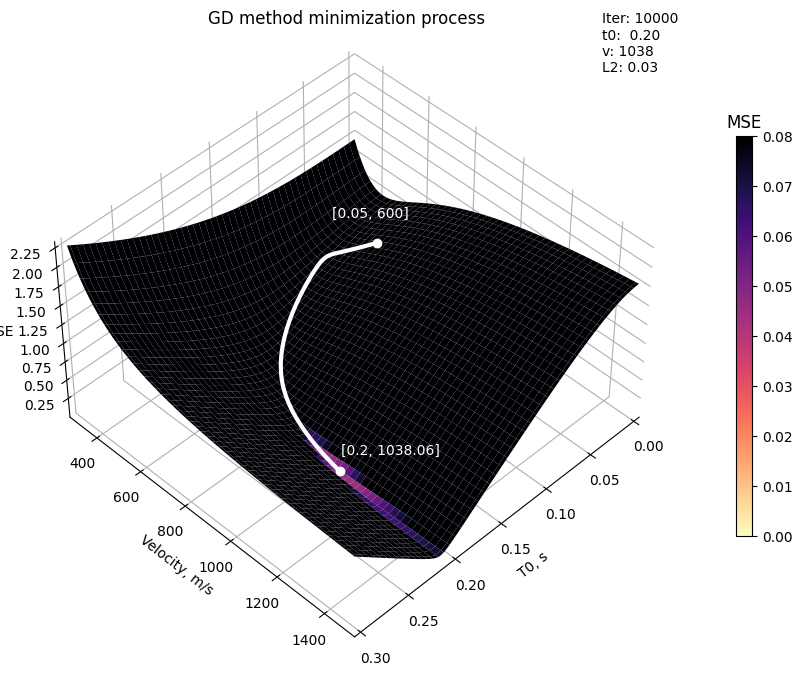

In [ ]:
# plt.rcParams["font.family"] = "arial"

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.set_box_aspect(aspect = (5,5,3))
ax.view_init(elev=45., azim=45)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')

t0_min, t0_max = 0, 0.3
v_min, v_max = 300, 1500

t_grid = np.linspace(t0_min, t0_max, 100)
v_grid = np.linspace(v_min, v_max, 100)
t0_values, v_values = np.meshgrid(t_grid, v_grid)

Z = np.zeros_like(v_values)
for i in range(t0_values.shape[0]):
    for j in range(t0_values.shape[1]):
        Z[i, j] = residuals([t0_values[i,j], v_values[i,j]], x, y, t_measured)

plt.title("GD method minimization process")
im = ax.plot_surface(t0_values, v_values, Z,cmap = "magma_r", clim = [0, 0.08])
ax.plot(params[:,0],params[:,1], params[:,2], 'white', zorder = 6, lw = 3)
ax.plot(params[0,0],params[0,1], params[0,2], 'white', zorder = 6, marker = "o")
ax.plot(params[-1,0],params[-1,1], params[-1,2], 'white', zorder = 6, marker = "o")

ax.set_xlim([0, 0.3])
ax.set_ylabel("Velocity, m/s")
ax.set_xlabel("T0, s")
ax.set_zlabel("MSE")
ax.set_ylim([300, 1500])
ax.text(0.1, 600, 1.6, "[0.05, 600]", c = "white")
ax.text(0.19, 1000, 0.07, "[0.2, 1038.06]", c = "white")
ax.text(0, 1300, 4, f"Iter: {len(params)-1}\nt0:  {params[-1,0]:.2f}\nv: {params[-1, 1]:.0f}\nL2: {params[-1, 2]:.2f}")

cax = fig.add_axes([1, 0.25, 0.02, 0.5])
fig.colorbar(im, cax=cax, orientation='vertical', shrink = .3)
plt.title("MSE")


plt.show()

# SciPy

In [ ]:
def callback(params):
    params_scipy.append([*params, residuals(params, x, y, t_measured)])

initial_guess = [0.05, 600]
params_scipy = [[*initial_guess, 0]]
bnds = ((0,None), (1, None))

# Call the optimizer (func residuals defined previously in GD-dedicated part)
result = minimize(fun = residuals,
                  x0 = initial_guess,
                  args=(x, y, t_measured),
                  tol = 1e-10,
                  bounds = bnds,
                  method = "tnc",
                  options={'disp': True},
                  callback = callback
                 )


# The optimal parameters are in result.x
t0_opt, v_opt = result.x
params_scipy = np.array(params_scipy)

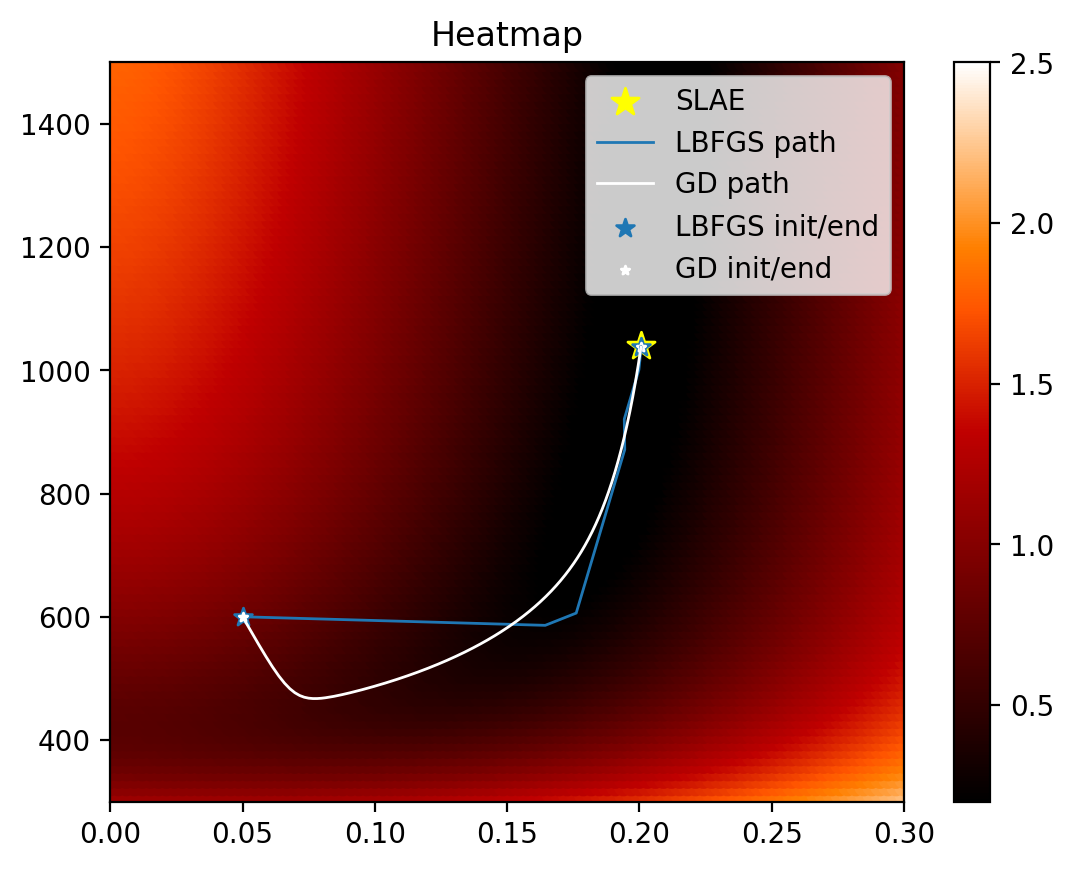

In [ ]:
plt.figure(dpi = 200)
plt.scatter(t0_values, v_values, c = Z, cmap = "gist_heat", clim = [0.2, 2.5], zorder = -1)
plt.colorbar()
plt.xlim([0, 0.3])
plt.ylim([300, 1500])

plt.title("Heatmap")
plt.scatter(*solution, c = "yellow", s = 105, marker = "*", zorder = 0, label = "SLAE")
plt.plot(params_scipy[:,0], params_scipy[:,1], c = "C0", lw = 1, label = "LBFGS path")
plt.plot(params[:,0],params[:,1], c = "white", lw = 1, label = "GD path")


plt.scatter(params_scipy[0,0],params_scipy[0,1], c = "C0", s = 45, marker = "*", label = "LBFGS init/end")
plt.scatter(params[0,0],params[0,1], c = "white", s = 10, marker = "*", label = "GD init/end", zorder = 2)

plt.scatter(params_scipy[-1,0],params_scipy[-1,1], c = "C0", s = 45, marker = "*")
plt.scatter(params[-1,0],params[-1,1], c = "white", s = 10, marker = "*")

plt.legend(loc = 1)
